In [63]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings

In [4]:
# Suppress the warning message
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
def read_data_from_csv(file_path):
    """
    Reads the data from a CSV file and returns a pandas DataFrame.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pandas DataFrame: DataFrame containing the data.
    """
    df = pd.read_csv(file_path)
    return df

In [6]:
def preprocess_data(data):
    """
    Performs data preprocessing steps on the DataFrame.

    Args:
        data (pandas DataFrame): DataFrame containing the data.

    Returns:
        pandas DataFrame: Preprocessed DataFrame.
    """
    data['horsepower'].replace('?', np.NaN, inplace=True)
    data['horsepower'] = data['horsepower'].astype(float)

    # Using KNNImputer to fill missing values in 'horsepower' column
    imputer = KNNImputer(n_neighbors=5)
    data['horsepower'] = imputer.fit_transform(data[['horsepower']])

    data.drop('car name', axis=1, inplace=True)
    
    return data

In [7]:
def add_features(data):
    """
    Performs feature engineering on the dataset.

    Args:
        data (pandas DataFrame): DataFrame containing the data.

    Returns:
        pandas DataFrame: DataFrame with extra features.
    """
    data['displacement_per_cylinder'] = data['displacement'] / data['cylinders']
    data['power_to_weight_ratio'] = data['horsepower'] / data['weight']
    data = data[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                'model year', 'origin', 'power_to_weight_ratio', 'displacement_per_cylinder']]
    return data

In [41]:
def plot_histogram(data):
    """
    Plots histogram for features in dataset.

    Args:
        data (pandas DataFrame): DataFrame containing the data.

    Returns:
        None
    """
    data_copy = data.copy()

    columns = data_copy.columns

    num_rows = (len(columns) - 1) // 3 + 1
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    axes = axes.flatten()

    for i, column in enumerate(columns):
        axes[i].hist(data_copy[column], bins=20)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')

    if len(columns) < num_rows * num_cols:
        for j in range(len(columns), num_rows * num_cols):
            fig.delaxes(axes[j])

    fig.tight_layout()

    plt.show()

In [8]:
def augment_data(data, num_augmentations=2, noise_std=0.1):
    """
    Generates augmented synthetic data based on the given data using data augmentation.

    Args:
        data (pandas DataFrame): DataFrame containing the original data.
        num_augmentations (int): Number of augmented instances to generate per original instance.
        noise_std (float): Standard deviation of Gaussian noise to add to attributes.

    Returns:
        pandas DataFrame: Augmented DataFrame with synthetic data.
    """
    augmented_data = []

    for _, row in data.iterrows():
        for _ in range(num_augmentations):
            augmented_instance = row.copy()

            for column in ['displacement', 'horsepower', 'weight', 'acceleration']:
                noise = np.random.normal(scale=noise_std)
                augmented_instance[column] = max(0, augmented_instance[column] + noise)

            augmented_data.append(augmented_instance)

    augmented_df = pd.DataFrame(augmented_data)
    augmented_df = shuffle(augmented_df).reset_index(drop=True)
    return augmented_df

In [9]:
def train_linear_regression(X_train, y_train):
    """
    Trains a Linear Regression model on the given training data.

    Args:
        X_train (pandas DataFrame): Features of the training data.
        y_train (pandas Series): Target variable of the training data.

    Returns:
        LinearRegression: Trained Linear Regression model.
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

In [10]:
def train_ridge_regression(X_train, y_train):
    """
    Trains a Ridge Regression model on the given training data.

    Args:
        X_train (pandas DataFrame): Features of the training data.
        y_train (pandas Series): Target variable of the training data.

    Returns:
        Ridge: Trained Ridge Regression model.
    """
    model = Ridge()
    model.fit(X_train, y_train)
    return model

In [11]:
def train_lasso_regression(X_train, y_train):
    """
    Trains a Lasso Regression model on the given training data.

    Args:
        X_train (pandas DataFrame): Features of the training data.
        y_train (pandas Series): Target variable of the training data.

    Returns:
        Lasso: Trained Lasso Regression model.
    """
    model = Lasso()
    model.fit(X_train, y_train)
    return model

In [12]:
def train_random_forest(X, y):
    """
    Trains a Random Forest Regressor using grid search for hyperparameter tuning.

    Args:
        X (pandas DataFrame): Features of the training data.
        y (pandas Series): Target variable of the training data.

    Returns:
        RandomForestRegressor: Trained Random Forest Regressor with best hyperparameters.
    """
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    rf_reg = RandomForestRegressor(random_state=0)
    grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

In [13]:
def train_decision_tree(X, y):
    """
    Trains a Decision Tree Regressor using grid search for hyperparameter tuning.

    Args:
        X (pandas DataFrame): Features of the training data.
        y (pandas Series): Target variable of the training data.

    Returns:
        DecisionTreeRegressor: Trained Decision Tree Regressor with best hyperparameters.
    """
    param_grid = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    dt_reg = DecisionTreeRegressor(random_state=0)
    grid_search = GridSearchCV(estimator=dt_reg, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

In [14]:
def train_gradient_boosting(X, y):
    """
    Trains a Gradient Boosting Regressor using grid search for hyperparameter tuning.

    Args:
        X (pandas DataFrame): Features of the training data.
        y (pandas Series): Target variable of the training data.

    Returns:
        GradientBoostingRegressor: Trained Gradient Boosting Regressor with best hyperparameters.
    """
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    gb_reg = GradientBoostingRegressor(random_state=0)
    grid_search = GridSearchCV(estimator=gb_reg, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

In [15]:
def build_stacking_regressor(base_models, meta_model):
    """
    Builds a Stacking Regressor by combining base models with a meta-model.

    Args:
        base_models (list): List of tuples, where each tuple contains a name and a base regression model.
        meta_model (regressor): The meta-model that combines predictions from base models.

    Returns:
        StackingRegressor: Stacking Regressor composed of base models and a meta-model.
    """
    return StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model
    )

In [27]:
# Load the dataset
file_path = 'auto-mpg.csv'
original_data = read_data_from_csv(file_path)
original_data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [28]:
# Check for missing values
original_data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [29]:
# Analyse the data types of features
original_data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [30]:
# This will display the unique values in each column of the dataframe
for column in original_data.columns:
    unique_values = original_data[column].unique()
    print(f"Unique values in {column}: {unique_values}, \nCount of unique values in {column}: {len(unique_values)}")

Unique values in mpg: [18.  15.  16.  17.  14.  24.  22.  21.  27.  26.  25.  10.  11.   9.
 28.  19.  12.  13.  23.  30.  31.  35.  20.  29.  32.  33.  17.5 15.5
 14.5 22.5 24.5 18.5 29.5 26.5 16.5 31.5 36.  25.5 33.5 20.5 30.5 21.5
 43.1 36.1 32.8 39.4 19.9 19.4 20.2 19.2 25.1 20.6 20.8 18.6 18.1 17.7
 27.5 27.2 30.9 21.1 23.2 23.8 23.9 20.3 21.6 16.2 19.8 22.3 17.6 18.2
 16.9 31.9 34.1 35.7 27.4 25.4 34.2 34.5 31.8 37.3 28.4 28.8 26.8 41.5
 38.1 32.1 37.2 26.4 24.3 19.1 34.3 29.8 31.3 37.  32.2 46.6 27.9 40.8
 44.3 43.4 36.4 44.6 40.9 33.8 32.7 23.7 23.6 32.4 26.6 25.8 23.5 39.1
 39.  35.1 32.3 37.7 34.7 34.4 29.9 33.7 32.9 31.6 28.1 30.7 24.2 22.4
 34.  38.  44. ], 
Count of unique values in mpg: 129
Unique values in cylinders: [8 4 6 3 5], 
Count of unique values in cylinders: 5
Unique values in displacement: [307.  350.  318.  304.  302.  429.  454.  440.  455.  390.  383.  340.
 400.  113.  198.  199.  200.   97.  110.  107.  104.  121.  360.  140.
  98.  232.  225.  250.  351. 

In [32]:
# Preprocess the data. Such as converting 'horsepower' to float and dropping 'car name'
original_data = preprocess_data(original_data)
original_data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


In [64]:
# Add some extra features
original_data = add_features(original_data)
original_data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,power_to_weight_ratio,displacement_per_cylinder
0,18.0,8,307.0,130.0,3504,12.0,70,1,0.037100,38.375
1,15.0,8,350.0,165.0,3693,11.5,70,1,0.044679,43.750
2,18.0,8,318.0,150.0,3436,11.0,70,1,0.043655,39.750
3,16.0,8,304.0,150.0,3433,12.0,70,1,0.043694,38.000
4,17.0,8,302.0,140.0,3449,10.5,70,1,0.040591,37.750
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1,0.030824,35.000
394,44.0,4,97.0,52.0,2130,24.6,82,2,0.024413,24.250
395,32.0,4,135.0,84.0,2295,11.6,82,1,0.036601,33.750
396,28.0,4,120.0,79.0,2625,18.6,82,1,0.030095,30.000


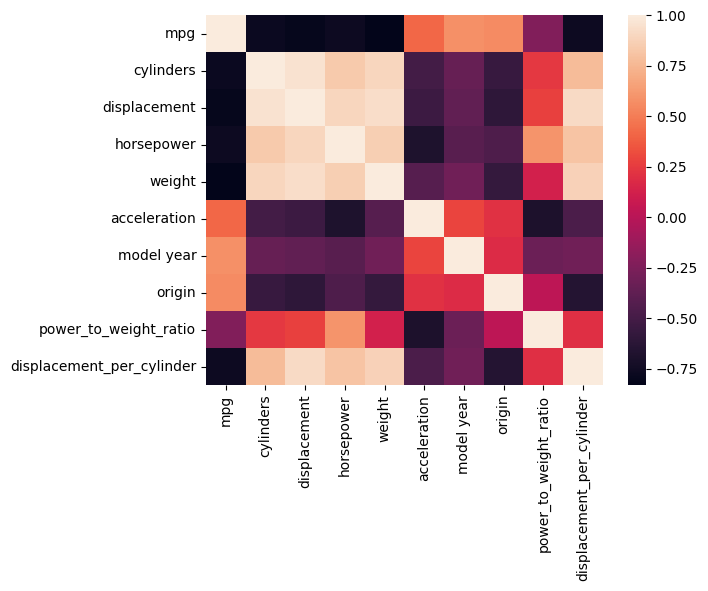

In [39]:
# Visualise correlation between features
dataplot = sb.heatmap(original_data.corr())

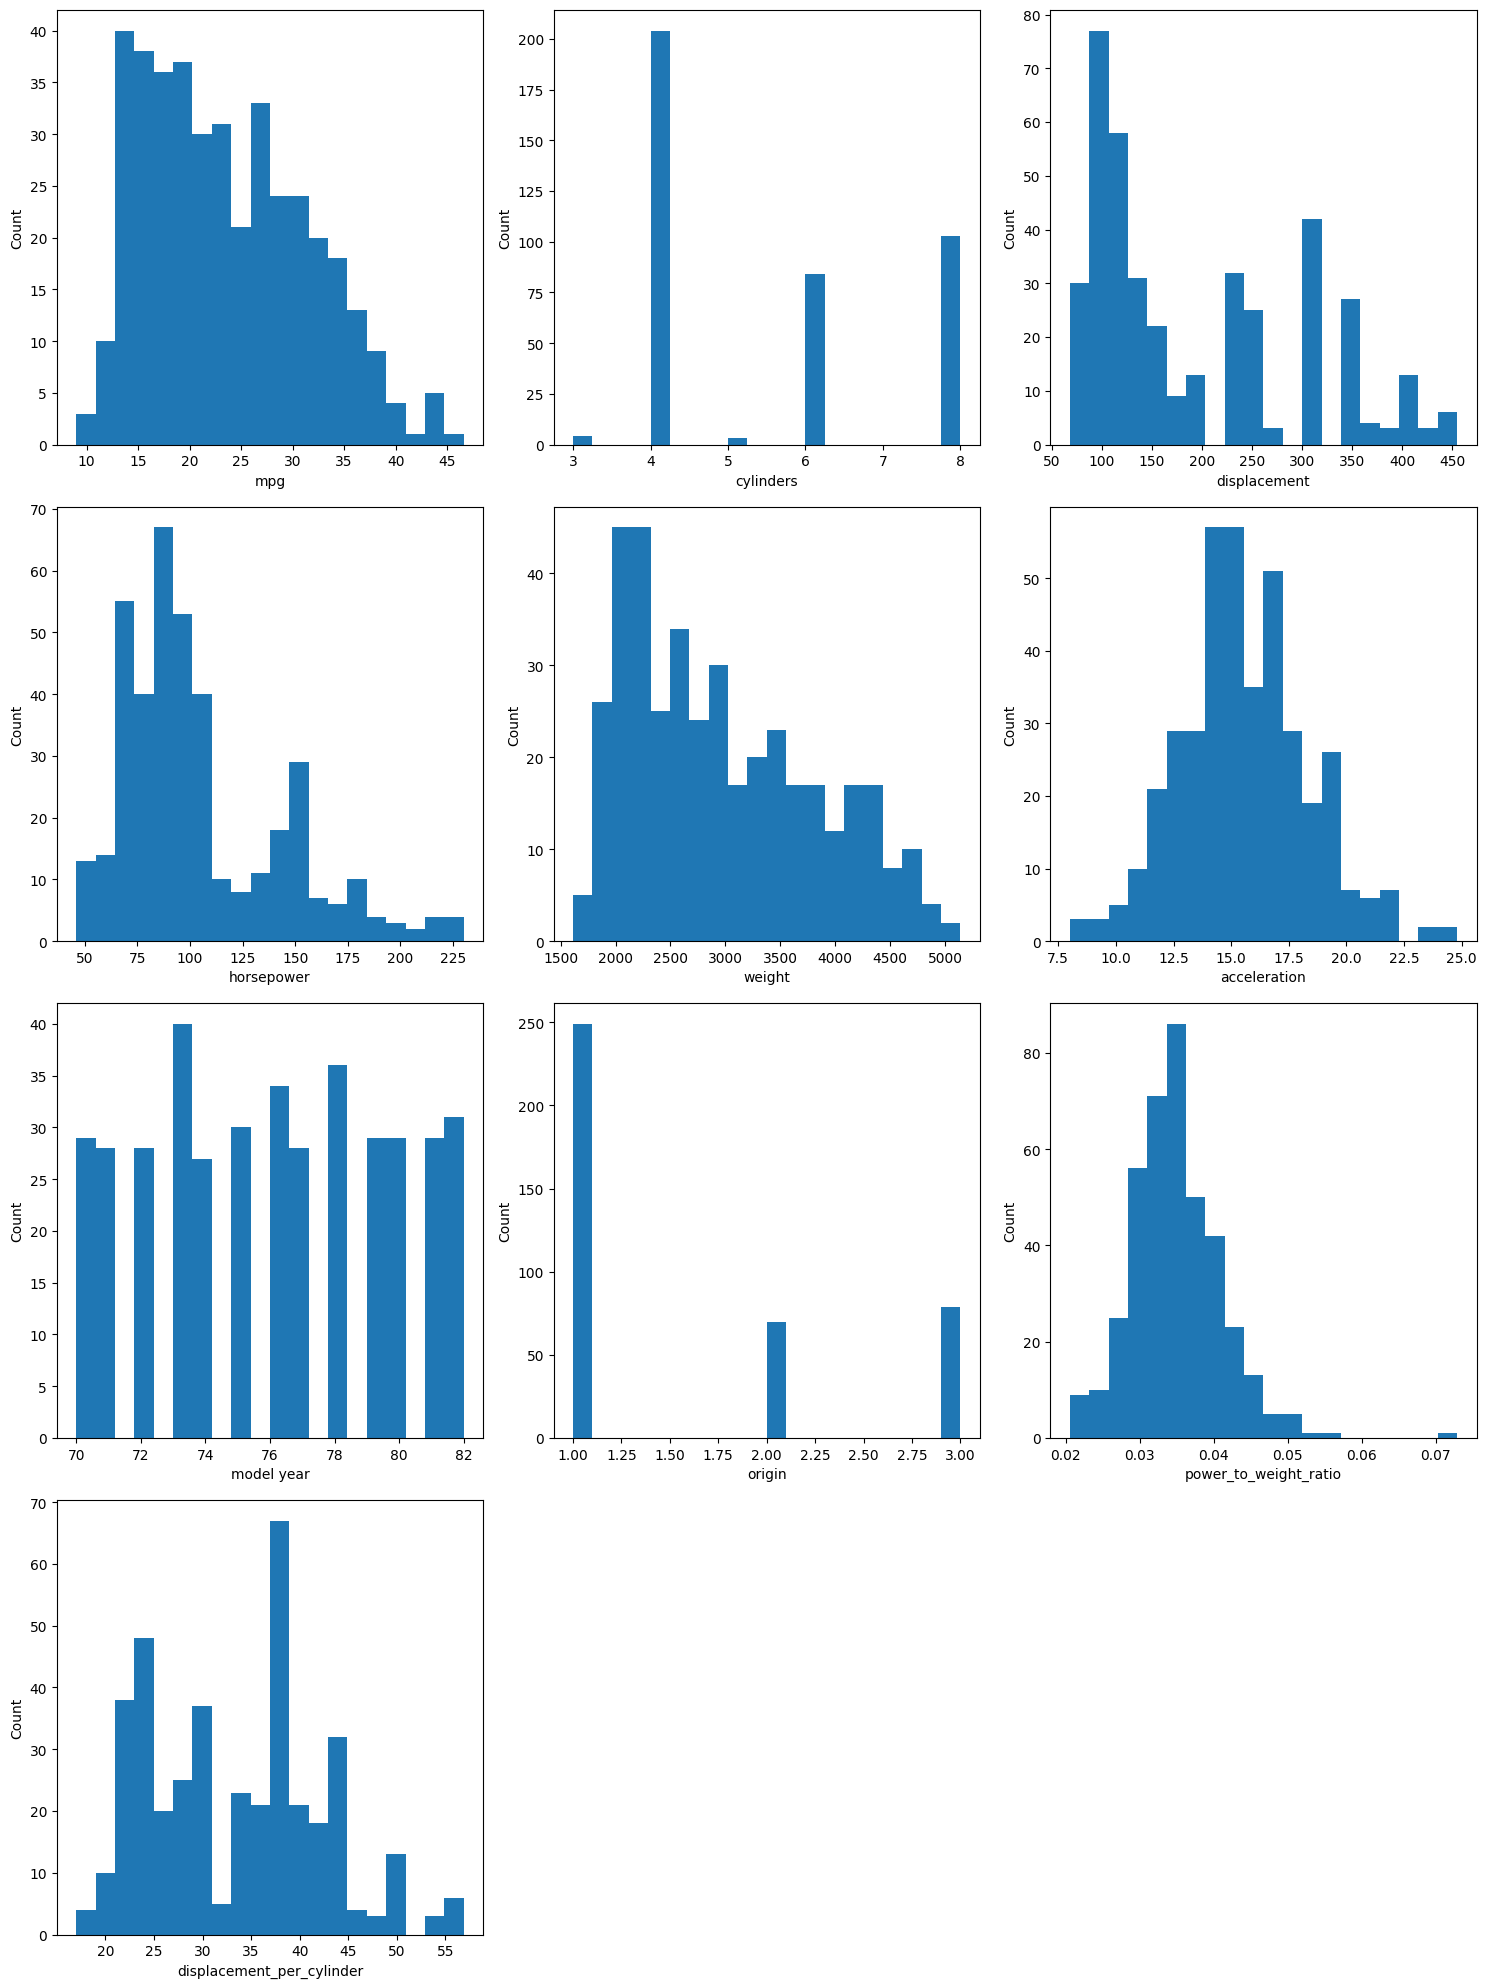

In [42]:
# Plot histograms of features
plot_histogram(original_data)

In [48]:
# Split the original data into features (X) and target variable (y)
X_original = original_data.iloc[:, 1:]
y_original = original_data['mpg']

# Split the original data into training and testing sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=0)

# Train models on original data
best_rf_model_original = train_random_forest(X_train_original, y_train_original)
best_dt_model_original = train_decision_tree(X_train_original, y_train_original)
best_gb_model_original = train_gradient_boosting(X_train_original, y_train_original)
lin_reg_model_original = train_linear_regression(X_train_original, y_train_original)
ridge_reg_model_original = train_ridge_regression(X_train_original, y_train_original)
lasso_reg_model_original = train_lasso_regression(X_train_original, y_train_original)

# Train stacking regressor on original data
base_models_original = [('lin_reg', lin_reg_model_original), ('ridge_reg', ridge_reg_model_original), ('lasso_reg', lasso_reg_model_original),
                        ('rf', best_rf_model_original), ('dt', best_dt_model_original), ('gb', best_gb_model_original)]
meta_model_original = LinearRegression()

stacking_regressor_original = build_stacking_regressor(base_models_original, meta_model_original)
stacking_regressor_original.fit(X_train_original, y_train_original)

# Evaluate model performance on original data
models = [best_rf_model_original, best_dt_model_original, best_gb_model_original, lin_reg_model_original, ridge_reg_model_original, lasso_reg_model_original, stacking_regressor_original]
model_names = ['Random Forest', 'Decision Tree', 'Gradient Boosting', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Stacking Regressor']

original_results = []

for model, name in zip(models, model_names):
    train_score = model.score(X_train_original, y_train_original)
    test_score = model.score(X_test_original, y_test_original)
    y_predicted_original = model.predict(X_test_original) 
    mae = mean_absolute_error(y_test_original, y_predicted_original)
    original_results.append({'Model': name, 'Train Score': train_score, 'Test Score': test_score, 'MAE': mae})

original_results_df = pd.DataFrame(original_results)
original_results_df

,Model,Train Score,Test Score,MAE
0,Random Forest,0.983136,0.900052,1.782004
1,Decision Tree,0.948539,0.860861,2.230840
2,Gradient Boosting,0.974110,0.893638,1.908018
3,Linear Regression,0.852843,0.837234,2.313014
4,Ridge Regression,0.848751,0.852070,2.321405
5,Lasso Regression,0.807917,0.827548,2.580218
6,Stacking Regressor,0.965137,0.896407,1.794147


In [50]:
# Augment data
augmented_data = augment_data(original_data)
print("After augmentation: ", augmented_data.shape)

# Split the augmented data into features (X_augmented) and target variable (y_augmented)
X_augmented = augmented_data.iloc[:, 1:]
y_augmented = augmented_data['mpg']

# Split the augmented data into training and testing sets
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(
    X_augmented, y_augmented, test_size=0.2, random_state=42
)

# Train models on augmented data
best_rf_model_augmented = train_random_forest(X_train_augmented, y_train_augmented)
best_dt_model_augmented = train_decision_tree(X_train_augmented, y_train_augmented)
best_gb_model_augmented = train_gradient_boosting(X_train_augmented, y_train_augmented)
lin_reg_model_augmented = train_linear_regression(X_train_augmented, y_train_augmented)
ridge_reg_model_augmented = train_ridge_regression(X_train_augmented, y_train_augmented)
lasso_reg_model_augmented = train_lasso_regression(X_train_augmented, y_train_augmented)

# Train stacking regressor on augmented data
base_models_augmented = [('lin_reg', lin_reg_model_augmented), ('ridge_reg', ridge_reg_model_augmented), ('lasso_reg', lasso_reg_model_augmented),
                            ('rf', best_rf_model_augmented), ('dt', best_dt_model_augmented), ('gb', best_gb_model_augmented)]
meta_model_augmented = LinearRegression()

stacking_regressor_augmented = build_stacking_regressor(base_models_augmented, meta_model_augmented)
stacking_regressor_augmented.fit(X_train_augmented, y_train_augmented)

# Evaluate model performance on augmented data
augmented_results = []

models = [best_rf_model_augmented, best_dt_model_augmented, best_gb_model_augmented, lin_reg_model_augmented, ridge_reg_model_augmented, lasso_reg_model_augmented, stacking_regressor_augmented]
model_names = ['Random Forest', 'Decision Tree', 'Gradient Boosting', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Stacking Regressor']

for model, name in zip(models, model_names):
    train_score = model.score(X_train_augmented, y_train_augmented)
    test_score = model.score(X_test_augmented, y_test_augmented)
    y_predicted_augmented = model.predict(X_test_augmented) 
    mae = mean_absolute_error(y_test_augmented, y_predicted_augmented)
    augmented_results.append({'Model': name, 'Train Score': train_score, 'Test Score': test_score, 'MAE': mae})

augmented_results_df = pd.DataFrame(augmented_results)
augmented_results_df

After augmentation:  (796, 10)


,Model,Train Score,Test Score,MAE
0,Random Forest,0.994433,0.921049,1.292312
1,Decision Tree,1.000000,0.858823,1.071250
2,Gradient Boosting,0.999912,0.937564,0.931371
3,Linear Regression,0.856113,0.835599,2.454077
4,Ridge Regression,0.854985,0.834194,2.458263
5,Lasso Regression,0.817825,0.795067,2.792019
6,Stacking Regressor,0.998858,0.930702,1.045923


In [51]:
# Create a dataframe to compare results on original and augmented data
comparison_results = pd.concat([original_results_df, augmented_results_df], keys=['Original Data', 'Augmented Data'])
comparison_results

Model  Train Score  Test Score       MAE
Original Data  0       Random Forest     0.983136    0.900052  1.782004
               1       Decision Tree     0.948539    0.860861  2.230840
               2   Gradient Boosting     0.974110    0.893638  1.908018
               3   Linear Regression     0.852843    0.837234  2.313014
               4    Ridge Regression     0.848751    0.852070  2.321405
               5    Lasso Regression     0.807917    0.827548  2.580218
               6  Stacking Regressor     0.965137    0.896407  1.794147
Augmented Data 0       Random Forest     0.994433    0.921049  1.292312
               1       Decision Tree     1.000000    0.858823  1.071250
               2   Gradient Boosting     0.999912    0.937564  0.931371
               3   Linear Regression     0.856113    0.835599  2.454077
               4    Ridge Regression     0.854985    0.834194  2.458263
               5    Lasso Regression     0.817825    0.795067  2.792019
               6  Stacking Regressor     0.998858    0.930702  1.045923